In [3]:
!pip install pyspark py4j

In [4]:
!pip install pandas openpyxl

In [5]:
!pip install mlxtend

In [6]:
pip install statsmodels

Import the packages

In [63]:
#import the packages

from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col, when
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.exceptions import ConvergenceWarning
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as pyplot
import warnings
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings("ignore", category=Warning)  # Ignore all warnings

Creating Spark session

In [31]:
#  initializes a Spark session named "End_term_assignment," to perform Spark operations in the application
spark=SparkSession.builder.appName('End_term_assignment').getOrCreate()

Loading the Data

In [32]:
# Path to your .gz file
file_path = '/content/transactionrecord.gz'

# Read the .gz file (assuming it contains a CSV)
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the DataFrame
df.show()

+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0ca|10.65|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23239|Set Of 4 Knick Kn...|             0ca|11.94|       6|     13069|United Kingdom|
|       581475|12/9/2019|    21705|Bag 500g Swirly M...|             0ca|10.65| 

## **Question: 1**

#### **Question: 1.1**

Using PySpark to do some of the data wrangling process, so that:

#### **Question 1.1.1**
For the ’NA’ in CustomerNo columns, change it to ’-1’.

In [33]:
# 1.1.1. Replace 'NA' in CustomerNo with '-1'
# Here we treat None as NA and replace it with -1
df = df.withColumn("CustomerNo", when(col("CustomerNo").isNull(), -1).otherwise(col("CustomerNo")))
df.show()


+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0ca|10.65|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23239|Set Of 4 Knick Kn...|             0ca|11.94|       6|     13069|United Kingdom|
|       581475|12/9/2019|    21705|Bag 500g Swirly M...|             0ca|10.65| 

#### **Question 1.1.2**
Process the text in productName column, only alphabet characters left, and save the processed result to a new column productName_process and show the first 5 rows.

In [34]:
# 1.1.2. Process the ProductName to keep only alphabetic characters
df = df.withColumn('productName_process', regexp_replace(col('ProductName'), '[^a-zA-Z]', ''))

# Show the first 5 rows
df.select("TransactionNo", "Date", "ProductNo", "ProductName", "CustomerNo", "productName_process").show(5)

+-------------+---------+---------+--------------------+----------+--------------------+
|TransactionNo|     Date|ProductNo|         ProductName|CustomerNo| productName_process|
+-------------+---------+---------+--------------------+----------+--------------------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|     17490|SetOfWoodenMarket...|
|       581475|12/9/2019|    22596|Christmas Star Wi...|     13069|ChristmasStarWish...|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|     13069|StorageTinVintage...|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|     13069|TreeTLightHolderW...|
|       581475|12/9/2019|    23239|Set Of 4 Knick Kn...|     13069|SetOfKnickKnackTi...|
+-------------+---------+---------+--------------------+----------+--------------------+
only showing top 5 rows



### **Question 1.2**:

Find out the revenue on each transaction date. In order to achieve the above, some wrangling work is required to be done:

#### **Question 1.2.1**

Using pyspark to calculate the revenue (price * Quantity) and save as float format in pyspark  dataframe to show the top 5 rows.

In [35]:
#1.2.1. Calculate the total revenue for each transaction
df = df.withColumn("Revenue", (col("Price") * col("Quantity")).cast("float"))

# Show the top 5 rows
df.select("TransactionNo", "Date", "Revenue").show(5)

+-------------+---------+-------+
|TransactionNo|     Date|Revenue|
+-------------+---------+-------+
|       581482|12/9/2019| 257.64|
|       581475|12/9/2019|  383.4|
|       581475|12/9/2019| 138.36|
|       581475|12/9/2019|  127.8|
|       581475|12/9/2019|  71.64|
+-------------+---------+-------+
only showing top 5 rows



#### **Question 1.2.2**
Transform the pyspark dataframe to pandas dataframe (named as df) and create the column transaction_date with date format according to Date. Print your df pandas dataframe with top 5 rows after creating the column transaction_date.

In [36]:
# 1.2.2. Transform to Pandas DataFrame and Create transaction_date Column
# Convert to Pandas DataFrame
df = df.toPandas()

# Convert 'Date' to datetime and create 'transaction_date' column
df['transaction_date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Print the top 5 rows of the Pandas DataFrame
df.head()

,TransactionNo,Date,ProductNo,ProductName,Product_category,Price,Quantity,CustomerNo,Country,productName_process,Revenue,transaction_date
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,0ca,21.47,12,17490,United Kingdom,SetOfWoodenMarketCrates,257.640015,2019-12-09
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,0ca,10.65,36,13069,United Kingdom,ChristmasStarWishListChalkboard,383.399994,2019-12-09
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,0ca,11.53,12,13069,United Kingdom,StorageTinVintageLeaf,138.360001,2019-12-09
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,0ca,10.65,12,13069,United Kingdom,TreeTLightHolderWillieWinkie,127.800003,2019-12-09
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,0ca,11.94,6,13069,United Kingdom,SetOfKnickKnackTinsPoppies,71.639999,2019-12-09


#### **Question 1.2.3**
Plot the sum of revenue on transaction_date in a line plot and find out any immediate pattern / insight?

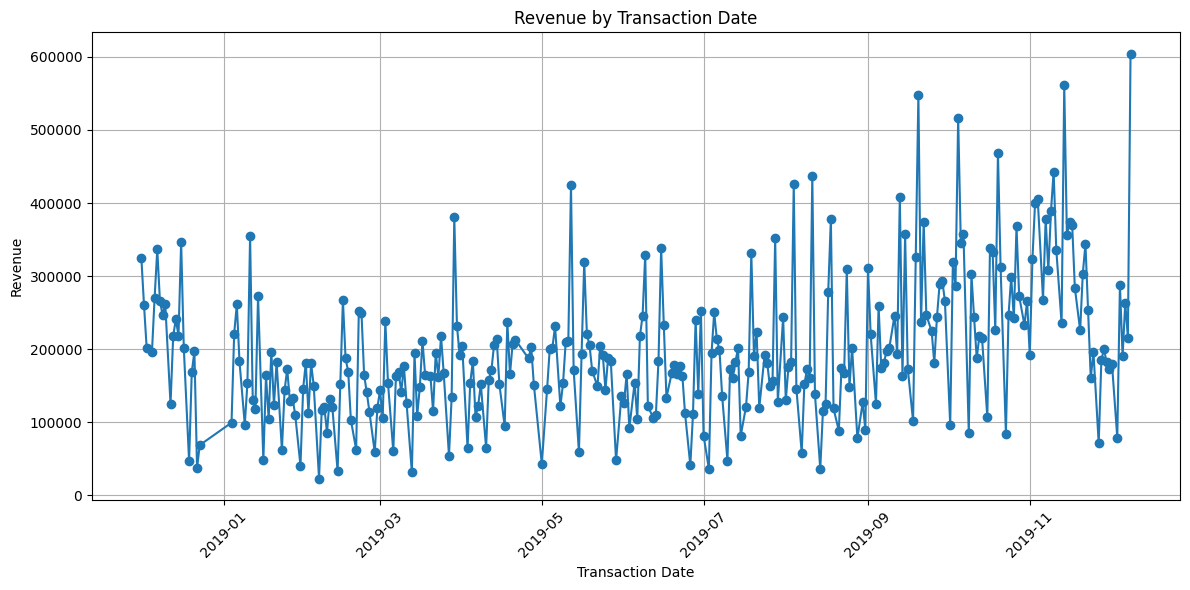

In [37]:
#1.2.3. Plot the Sum of Revenue by transaction_date
# Group by transaction_date and sum the revenue
revenue_by_date = df.groupby('transaction_date')['Revenue'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(revenue_by_date['transaction_date'], revenue_by_date['Revenue'], marker='o')
plt.title('Revenue by Transaction Date')
plt.xlabel('Transaction Date')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

### **Question 1.3:**
Let’s continue to analyse on the transaction_date vs revenue.
#### **Question 1.3.1**
Determine which workday (day of the week), generates the most sales (plotting the results in a line chart with workday on averaged revenues).

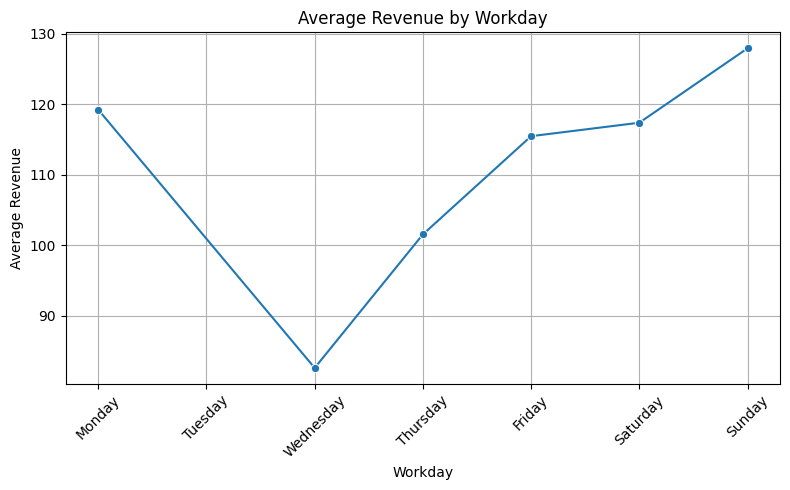

The workday that generates the most sales is: Sunday


In [38]:
# Add a column for the day of the week
df['workday'] = df['transaction_date'].dt.day_name()

# Group by workday and calculate the average revenue
average_revenue_by_workday = df.groupby('workday')['Revenue'].mean().reset_index()

# sort by workday to follow the order (mon-sun)
order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_revenue_by_workday['workday'] = pd.Categorical(average_revenue_by_workday['workday'], categories=order, ordered=True)
average_revenue_by_workday=average_revenue_by_workday.sort_values('workday')

# Plotting the results
plt.figure(figsize=(8, 5))
sns.lineplot(data=average_revenue_by_workday, x='workday', y='Revenue', marker='o')
plt.title('Average Revenue by Workday')
plt.xlabel('Workday')
plt.ylabel('Average Revenue')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Identify the workday with the highest average revenue
max_revenue_workday = average_revenue_by_workday.loc[average_revenue_by_workday['Revenue'].idxmax(), 'workday']
print(f"The workday that generates the most sales is: {max_revenue_workday}")


#### **Question 1.3.2**
Identify the name of product (column productName_process) that contributes the highest revenue on ‘that workday’ (you need to find out from 1.3.1) and the name of product (column productName_process) that has the highest sales volume (sum of the Quantity), no need to remove negative quantity transactions.) on ‘that workday’ (you need to find out from 1.3.1).

In [39]:
# Filter the DataFrame for the max revenue workday
max_revenue_df = df[df['workday'] == max_revenue_workday]

# Product with the highest revenue
highest_revenue_product = max_revenue_df.groupby('productName_process')['Revenue'].sum().idxmax()
highest_revenue_value = max_revenue_df.groupby('productName_process')['Revenue'].sum().max()

# Product with the highest sales volume
highest_volume_product = max_revenue_df.groupby('productName_process')['Quantity'].sum().idxmax()
highest_volume_value = max_revenue_df.groupby('productName_process')['Quantity'].sum().max()

print(f"Product with the highest revenue on {max_revenue_workday}: {highest_revenue_product} (${highest_revenue_value:.2f})")
print(f"Product with the highest sales volume on {max_revenue_workday}: {highest_volume_product} (Quantity: {highest_volume_value})")

Product with the highest revenue on Sunday: WorldWarGlidersAsstdDesigns ($187081.34)
Product with the highest sales volume on Sunday: WorldWarGlidersAsstdDesigns (Quantity: 18051)


#### **Question 1.3.3**
Please provide two plots showing the top 5 products that contribute the highest revenues in general and top 5 products that have the highest sales volumes in general.


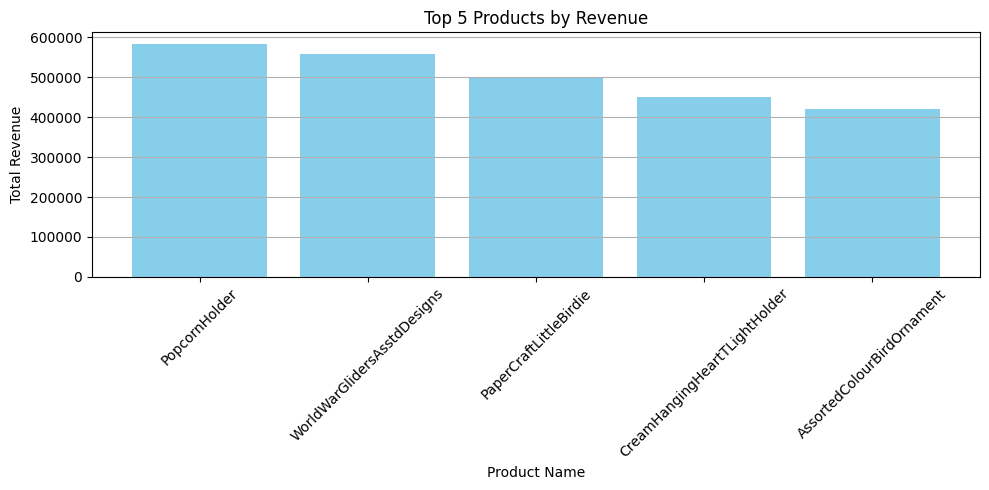

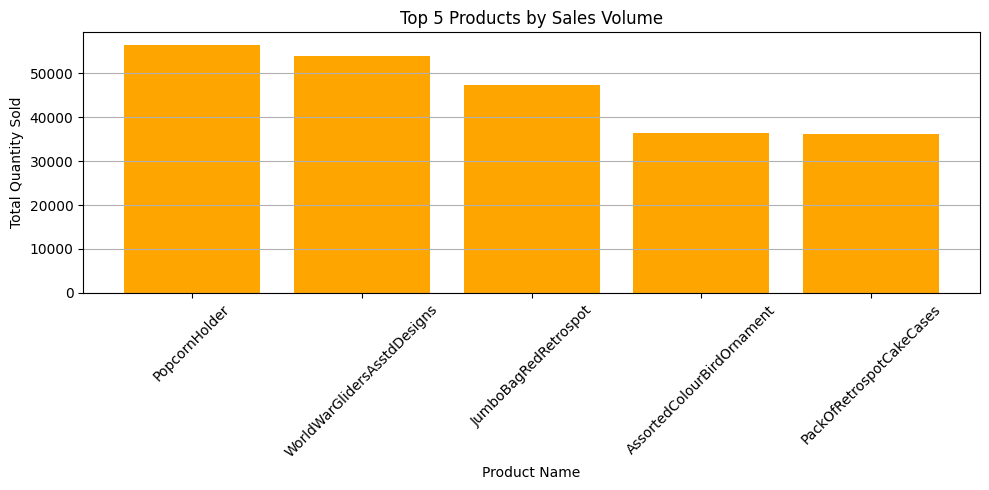

In [40]:
# Top 5 products by revenue
top_revenue_products = df.groupby('productName_process')['Revenue'].sum().nlargest(5).reset_index()

# Plotting top 5 products by revenue
plt.figure(figsize=(10, 5))
plt.bar(top_revenue_products['productName_process'], top_revenue_products['Revenue'], color='skyblue')
plt.title('Top 5 Products by Revenue')
plt.xlabel('Product Name')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Top 5 products by sales volume
top_volume_products = df.groupby('productName_process')['Quantity'].sum().nlargest(5).reset_index()

# Plotting top 5 products by sales volume
plt.figure(figsize=(10, 5))
plt.bar(top_volume_products['productName_process'], top_volume_products['Quantity'], color='orange')
plt.title('Top 5 Products by Sales Volume')
plt.xlabel('Product Name')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### **Question 1.4:**
Which country generates the highest revenue? Additionally, identify the month in that country that has the highest revenue.

In [41]:
# Extract month and year
df['month'] = df['transaction_date'].dt.month_name()
df['year'] = df['transaction_date'].dt.year


#Find the Country with Highest Revenue
#Calculate the total revenue for each country.

# Group by country and sum the revenue
country_revenue = df.groupby('Country')['Revenue'].sum().reset_index()

# Identify the country with the highest revenue
max_revenue_country = country_revenue.loc[country_revenue['Revenue'].idxmax()]

print(f"The country that generates the highest revenue is: {max_revenue_country['Country']} (${max_revenue_country['Revenue']:.2f})")


#Identify the Month with Highest Revenue in that Country
#Filter the DataFrame for the identified country and group by month to find the month with the highest revenue.

# Filter for the country with the highest revenue
highest_revenue_country_df = df[df['Country'] == max_revenue_country['Country']]

# Group by month and sum the revenue
monthly_revenue = highest_revenue_country_df.groupby('month')['Revenue'].sum().reset_index()

# Identify the month with the highest revenue
max_revenue_month = monthly_revenue.loc[monthly_revenue['Revenue'].idxmax()]

print(f"The month with the highest revenue in {max_revenue_country['Country']} is: {max_revenue_month['month']} (${max_revenue_month['Revenue']:.2f})")


The country that generates the highest revenue is: United Kingdom ($49994032.00)
The month with the highest revenue in United Kingdom is: November ($6737640.00)


### **Question 1.5:**

Let’s do some analysis on the CustomerNo and their transactions. Determine the shopping frequency of customers to identify who shops most frequently (find out the highest distinct count of transactionNo on customer level, be careful with those transactions that is not for shopping – filter those transaction quantity <= 0). Also, find out what products (column productName_process) ‘this customer’ typically buys based on the Quantity of products purchased.

In [42]:
#Filter for valid transactions (Quantity > 0)
valid_transactions_df = df[df['Quantity'] > 0]

#Determine the Shopping Frequency of Each Customer
# Count distinct TransactionNo per CustomerNo
customer_frequency = valid_transactions_df.groupby('CustomerNo')['TransactionNo'].nunique().reset_index()

# Identify the customer with the highest frequency
most_frequent_customer = customer_frequency.loc[customer_frequency['TransactionNo'].idxmax()]

print(f"The customer who shops most frequently is: {most_frequent_customer['CustomerNo']} with {most_frequent_customer['TransactionNo']} transactions.")

#Find Products Typically Bought by the Most Frequent Customer
# Filter the DataFrame for the most frequent customer
frequent_customer_df = valid_transactions_df[valid_transactions_df['CustomerNo'] == most_frequent_customer['CustomerNo']]

# Group by productName_process and sum the Quantity
products_purchased = frequent_customer_df.groupby('productName_process')['Quantity'].sum().reset_index()

# Sort by Quantity to identify the most purchased products
top_products = products_purchased.sort_values(by='Quantity', ascending=False)

print("Products typically bought by the most frequent customer:")
top_products.head(20)



The customer who shops most frequently is: 12748 with 207 transactions.
Products typically bought by the most frequent customer:


,productName_process,Quantity
1609,VictorianMetalPostcardSpring,595
1706,WorldWarGlidersAsstdDesigns,480
1273,RoseScentCandleJewelledDrawer,408
201,CartoonPencilSharpeners,405
1483,SmallWhiteRetrospotMugInBox,390
1608,VanillaScentCandleJewelledBox,380
1480,SmallRedRetrospotMugInBox,372
163,BubblegumRingAssorted,318
1132,PopartWoodenPencilsAsst,300
927,OceanScentCandleInJewelledBox,225


### **Question 1.6:**

As the data scientist, you would like to build a basket-level analysis on the product customer buying (filter the ‘df’ dataframe with df[’Quantity’]>0). In this task, you need to:

#### **Question 1.6.1**
Group by the transactionNo and aggregate the category of product (column product_category) into list on transactionNo level. Similarly, group and aggregate name of product (column productName_process) into list on transactionNo level.

In [43]:
#Filter for valid transactions (Quantity > 0)
valid_transactions_df = df[df['Quantity'] > 0]

#Group by TransactionNo and Aggregate Categories and Product Names
# Group by TransactionNo and aggregate product_category and productName
basket_analysis = valid_transactions_df.groupby('TransactionNo').agg(
    product_category_list=('Product_category', lambda x: list(x)),
    productName_process_list=('productName_process', lambda x: list(x))
).reset_index()

# Display the result
basket_analysis.head(10)


,TransactionNo,product_category_list,productName_process_list
0,536365,"[0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca]","[CreamHangingHeartTLightHolder, WhiteMoroccanM..."
1,536366,"[0ca, 0ca]","[HandWarmerUnionJack, HandWarmerRedRetrospot]"
2,536367,"[0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, ...","[AssortedColourBirdOrnament, PoppysPlayhouseBe..."
3,536368,"[0ca, 0ca, 0ca, 0ca]","[JamMakingSetWithJars, RedCoatRackParisFashion..."
4,536369,[0ca],[BathBuildingBlockWord]
5,536370,"[0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, ...","[AlarmClockBakelikePink, AlarmClockBakelikeRed..."
6,536371,[0ca],[PaperChainKitSChristmas]
7,536372,"[0ca, 0ca]","[HandWarmerRedRetrospot, HandWarmerUnionJack]"
8,536373,"[0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, ...","[CreamHangingHeartTLightHolder, WhiteMoroccanM..."
9,536374,[0ca],[VictorianSewingBoxLarge]


#### **Question 1.6.2**
Removing duplicates on adjacent elements in the list from product_category you obtained from 1.6.1, such as [product category 1, product category 1, product category 2, ...] will be processed as [product category 1, product category 2,....]. After this processing, there will be no duplicates on on adjacent elements in the list. Please save your processed dataframe as ‘df_1’ and print the top 10 rows.

In [44]:
#Remove Duplicates on Adjacent Elements
def remove_adjacent_duplicates(lst):
    if not lst:
        return lst
    new_lst = [lst[0]]  # Start with the first element
    for item in lst[1:]:
        if item != new_lst[-1]:  # Only add if different from last added
            new_lst.append(item)
    return new_lst

# Apply the function to remove adjacent duplicates
basket_analysis['product_category_list'] = basket_analysis['product_category_list'].apply(remove_adjacent_duplicates)

# Rename the processed DataFrame as 'df_1'
df_1 = basket_analysis

# Display the top 10 rows of df_1
print("Processed DataFrame 'df_1' with top 10 rows:")
df_1.head(10)

Processed DataFrame 'df_1' with top 10 rows:


,TransactionNo,product_category_list,productName_process_list
0,536365,[0ca],"[CreamHangingHeartTLightHolder, WhiteMoroccanM..."
1,536366,[0ca],"[HandWarmerUnionJack, HandWarmerRedRetrospot]"
2,536367,[0ca],"[AssortedColourBirdOrnament, PoppysPlayhouseBe..."
3,536368,[0ca],"[JamMakingSetWithJars, RedCoatRackParisFashion..."
4,536369,[0ca],[BathBuildingBlockWord]
5,536370,[0ca],"[AlarmClockBakelikePink, AlarmClockBakelikeRed..."
6,536371,[0ca],[PaperChainKitSChristmas]
7,536372,[0ca],"[HandWarmerRedRetrospot, HandWarmerUnionJack]"
8,536373,[0ca],"[CreamHangingHeartTLightHolder, WhiteMoroccanM..."
9,536374,[0ca],[VictorianSewingBoxLarge]


### **Question 1.7:**
Continue work on the results of question 1.6, now for each of the transaction, you will have a list of product categories. To further conduct the analysis, you need to finish below by using dataframe ‘df_1’:

#### **Question 1.7.1**
Create new column prod_len to find out the length of the list from product_category on each transaction. Print the first five rows of dataframe ‘df_1’.

In [45]:
#Calculate the Length of the Product Category List
# Calculate the length of the product category list and create a new column 'prod_len'
df_1['prod_len'] = df_1['product_category_list'].apply(len)

# Print the first five rows of the dataframe
print("First five rows of 'df_1' with 'prod_len':")
df_1.head(5)


First five rows of 'df_1' with 'prod_len':


,TransactionNo,product_category_list,productName_process_list,prod_len
0,536365,[0ca],"[CreamHangingHeartTLightHolder, WhiteMoroccanM...",1
1,536366,[0ca],"[HandWarmerUnionJack, HandWarmerRedRetrospot]",1
2,536367,[0ca],"[AssortedColourBirdOrnament, PoppysPlayhouseBe...",1
3,536368,[0ca],"[JamMakingSetWithJars, RedCoatRackParisFashion...",1
4,536369,[0ca],[BathBuildingBlockWord],1


#### **Question 1.7.2**

Transform the list in product_category from [productcategory1, productcategory2...] to ‘start >
productcategory1 > productcategory2 > ... > conversion’ with new column path. You need to add ‘start’ as the first element, and ‘conversion’ as the last. Also you need to use ‘ > ’ to connect each of the transition on products (there is a space between the elements and the transition symbol >). The final format after the transition is given in example as below fig. 2. Define the function data_processing to achieve above with three arguments: df which is the dataframe name, maxlength with default value of 3 for filtering the dataframe with prod_len" <=maxlength and minlength with default value of 1 for filtering the dataframe with prod_len >=minlength. The function data_processing will return the new dataframe‘df_2’. Run your defined function with dataframe ‘df_1’, maxlength = 5 and minlength = 2, print the dataframe ‘df_2’ with top 10 rows.

In [46]:
#Transform the Product Category List to a Path Format
#Define a Function to Create the Path Format

def data_processing(df, maxlength=3, minlength=1):
    # Filter the DataFrame based on the prod_len
    filtered_df = df[(df['prod_len'] <= maxlength) & (df['prod_len'] >= minlength)]

    # Create the 'path' column
    filtered_df['path'] = 'start > ' + filtered_df['product_category_list'].apply(lambda x: ' > '.join(x)) + ' > conversion'

    return filtered_df


#Apply the Function to Get df_2
#Run the Function with the Required Parameters

# Create df_2 using the data_processing function
df_2 = data_processing(df_1, maxlength=5, minlength=2)

# Print the top 10 rows of df_2
print("DataFrame 'df_2' with top 10 rows:")
df_2.head(10)

DataFrame 'df_2' with top 10 rows:


,TransactionNo,product_category_list,productName_process_list,prod_len,path
13,536378,"[0ca, 1ca, 0ca]","[StrawberryCharlotteBag, ChildrensCutleryRetro...",3,start > 0ca > 1ca > 0ca > conversion
27,536395,"[0ca, 1ca, 0ca]","[BlackHeartCardHolder, AssortedColourBirdOrnam...",3,start > 0ca > 1ca > 0ca > conversion
36,536404,"[0ca, 1ca, 0ca, 4ca, 0ca]","[HeartIvoryTrellisSmall, ClearDrawerKnobAcryli...",5,start > 0ca > 1ca > 0ca > 4ca > 0ca > conversion
40,536408,"[0ca, 1ca, 0ca]","[MagicDrawingSlateDinosaur, MagicDrawingSlateB...",3,start > 0ca > 1ca > 0ca > conversion
42,536412,"[0ca, 4ca, 0ca]","[RoundSnackBoxesSetOfWoodland, RoundSnackBoxes...",3,start > 0ca > 4ca > 0ca > conversion
43,536415,"[0ca, 1ca, 0ca]","[CakeCasesVintageChristmas, PaperChainKitVinta...",3,start > 0ca > 1ca > 0ca > conversion
52,536464,"[0ca, 1ca, 0ca]","[BlackSweetheartBracelet, DiamanteHairGripPack...",3,start > 0ca > 1ca > 0ca > conversion
72,536532,"[0ca, 1ca, 0ca]","[BoxOfCocktailParasols, GrowYourOwnPlantInACan...",3,start > 0ca > 1ca > 0ca > conversion
82,536542,"[0ca, 4ca]","[RecyclingBagRetrospot, JumboStorageBagSkulls,...",2,start > 0ca > 4ca > conversion
83,536544,"[0ca, 1ca, 0ca, 4ca, 0ca]","[DecorativeRoseBathroomBottle, DecorativeCatsB...",5,start > 0ca > 1ca > 0ca > 4ca > 0ca > conversion


### **Question 1.8:**

Continue to work on the results of question 1.7, the dataframe ‘df_2’, we would like to build the transition matrix together, but before we actually conduct the programming, we will need to finish few questions for exploration:

#### **Question 1.8.1**

Check on your transaction level basket with results from question 1.7, could you please find out respectively how many transactions ended with pattern ‘... > 0ca > conversion’ / ‘...> 1ca > conversion’ / ‘... > 2ca > conversion’ / ‘... > 3ca > conversion’ / ‘... > 4ca > conversion’ (1 result for each pattern, total 5 results are expected).

In [47]:
# Task 1.8.1: Count transactions ending with specific patterns
patterns_ending = ['0ca > conversion', '1ca > conversion', '2ca > conversion', '3ca > conversion', '4ca > conversion']

# Check how many transactions end with these patterns
for pattern in patterns_ending:
    count = df_2['path'].apply(lambda x: x.endswith(pattern)).sum()
    print(f"Number of transactions ending with '{pattern}': {count}")

Number of transactions ending with '0ca > conversion': 3056
Number of transactions ending with '1ca > conversion': 26
Number of transactions ending with '2ca > conversion': 144
Number of transactions ending with '3ca > conversion': 68
Number of transactions ending with '4ca > conversion': 198


#### **Question 1.8.2**
Check on your transaction level basket with results from question 1.7, could you please find out respectively how many times the transactions contains ‘0ca > 0ca’ / ‘0ca > 1ca’ / ‘0ca > 2ca’ / ‘0ca > 3ca’ / ‘0ca > 4ca’ / ‘0ca > conversion’ in the whole data (1 result for each pattern, total 6 results are expected and each transaction could contain those patterns multiple times, such as ‘start > 0ca > 1ca > 0ca > 1ca > conversion’ will count ‘two’ times with pattern ‘0ca > 1ca’, if there is not any, then return 0, you need to sum the counts from each transaction to return the final value).

In [48]:
# Task 1.8.2: Count occurrences of specific patterns within the entire path (can occur multiple times in a transaction)
patterns_within = ['0ca > 0ca', '0ca > 1ca', '0ca > 2ca', '0ca > 3ca', '0ca > 4ca', '0ca > conversion']

# Count occurrences of each pattern within the path and sum them up
for pattern in patterns_within:
    count = df_2['path'].apply(lambda x: x.count(pattern)).sum()
    print(f"Total occurrences of '{pattern}' in all transactions: {count}")

Total occurrences of '0ca > 0ca' in all transactions: 0
Total occurrences of '0ca > 1ca' in all transactions: 1222
Total occurrences of '0ca > 2ca' in all transactions: 1137
Total occurrences of '0ca > 3ca' in all transactions: 343
Total occurrences of '0ca > 4ca' in all transactions: 1198
Total occurrences of '0ca > conversion' in all transactions: 3056


#### **Question 1.8.3**
Check on your transaction level basket with results from task question 1.7, could you please find out how many times the transactions contains ‘...> 0ca > ...’ in the whole data (1 result is expected and each transaction could contain the pattern multiple times, such as ‘start > 0ca > 1ca > 0ca > 1ca > conversion’ will count ‘two’ times, you need to sum the counts from each transaction to return the final value).

In [49]:
# 1.8.3 Count occurrences of the pattern '... > 0ca > ...'
total_0ca_pattern_count = df_2['path'].str.count('> 0ca >').sum()
print(f"Total occurrences of the pattern '... > 0ca > ...' in all transactions: {total_0ca_pattern_count}")


Total occurrences of the pattern '... > 0ca > ...' in all transactions: 6956


#### **Question 1.8.4**
Use the 6 results from 1.8.2 to divide the result from 1.8.3 and then sum all of them and return the value.

In [ ]:
# 1.8.4 Calculate the final value based on the previous counts
patterns_within = ['0ca > 0ca', '0ca > 1ca', '0ca > 2ca', '0ca > 3ca', '0ca > 4ca', '0ca > conversion']

# Calculate and print the counts for each pattern
pattern_counts = {}
for pattern in patterns_within:
    count = df_2['path'].apply(lambda x: x.count(pattern)).sum()
    pattern_counts[pattern] = count
    print(f"Pattern '{pattern}' occurs {count} times.")

print("\n")

# Task 1.8.4: Compute ratios and final sum
ratios = {}
for pattern, count in pattern_counts.items():
    ratio = count / total_0ca_pattern_count if total_0ca_pattern_count > 0 else 0
    ratios[pattern] = ratio
    print(f"Ratio for pattern '{pattern}' is: {ratio}")

# Sum the ratios to get the final value
final_value = sum(ratios.values())
print(f"Final value (sum of ratios): {final_value}")

Pattern '0ca > 0ca' occurs 0 times.
Pattern '0ca > 1ca' occurs 1222 times.
Pattern '0ca > 2ca' occurs 1137 times.
Pattern '0ca > 3ca' occurs 343 times.
Pattern '0ca > 4ca' occurs 1198 times.
Pattern '0ca > conversion' occurs 3056 times.


Ratio for pattern '0ca > 0ca' is: 0.0
Ratio for pattern '0ca > 1ca' is: 0.17567567567567569
Ratio for pattern '0ca > 2ca' is: 0.16345600920069006
Ratio for pattern '0ca > 3ca' is: 0.04930994824611846
Ratio for pattern '0ca > 4ca' is: 0.17222541690626797
Ratio for pattern '0ca > conversion' is: 0.43933294997124783
Final value (sum of ratios): 1.0


### **Question 1.9:**

Let’s now look at the question 1.6 again, you have the list of product and list of product category for each transaction. We will use the transactionNo and productName_process to conduct the Association rule learning.

#### **Question 1.9.1**
Work on the dataframe df from question 1.2 (filter out the transaction with negative quantity value and also only keep those top 100 products by ranking the sum of quantity) and build the transaction level product dataframe (each row represents transactionNo and productName_process become the columns, the value in the column is the Quantity). Hint: you might consider to use pivot function in pandas.

In [ ]:
# 1.9.1 Filter out transactions with negative quantity values
df_filtered = df[df['Quantity'] > 0]  

# Rank products based on sum of quantity, select top 100
top_products = df_filtered.groupby('productName_process')['Quantity'].sum().nlargest(100).index  

# Filter the DataFrame to keep only the top 100 products
df_top_products = df_filtered[df_filtered['productName_process'].isin(top_products)]  

# Pivot the DataFrame to create a transaction-level view
df_transaction_level = df_top_products.pivot_table(index='TransactionNo', 
                                                   columns='productName_process',  
                                                   values='Quantity', 
                                                   aggfunc='sum', 
                                                   fill_value=0)  

# Show the transaction-level DataFrame
df_transaction_level.head()  

productName_process,AgedGlassSilverTLightHolder,AntiqueSilverTLightGlass,AssortedColourBirdOrnament,AssortedColoursSilkFan,AssortedFlowerColourLeis,AsstdDesigndPaperStickers,BaggSwirlyMarbles,BlackRecordCoverFrame,BrocadeRingPurse,BubblegumRingAssorted,...,StrawberryCharlotteBag,SweetheartFairyCakeCases,TeatimeFairyCakeCases,TravelCardWalletKeepCalm,VictorianGlassHangingTLight,VintageSnapCards,WoodenHeartChristmasScandinavian,WoodenStarChristmasScandinavian,WoodlandCharlotteBag,WorldWarGlidersAsstdDesigns
TransactionNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,32,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536371,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### **Question 1.9.2**
Run the apriori algorithm to identify items with minimum support of 1.5% (only looking at baskets with 4 or more items).
Hint: you might consider to use mlxtend.frequent_patterns to run apriori rules.

In [ ]:
#1.9.2  
# Binarize the DataFrame (Convert quantities to binary (1 if present, else 0))
df_transaction_level = df_transaction_level.map(lambda x: 1 if x > 0 else 0)  

# Filter transactions with 4 or more items
df_transaction_level['num_items'] = (df_transaction_level > 0).sum(axis=1)  
df_filtered_baskets = df_transaction_level[df_transaction_level['num_items'] >= 4].drop(columns='num_items')  
df_filtered_baskets_boolean = df_filtered_baskets.astype(bool) 

# Run Apriori algorithm with minimum support of 1.5%
frequent_itemsets = apriori(df_filtered_baskets_boolean, min_support=0.015, use_colnames=True)  

# Show frequent itemsets
frequent_itemsets 

,support,itemsets
0,0.031276,(AgedGlassSilverTLightHolder)
1,0.085835,(AntiqueSilverTLightGlass)
2,0.126928,(AssortedColourBirdOrnament)
3,0.054698,(AssortedColoursSilkFan)
4,0.057083,(BaggSwirlyMarbles)
...,...,...
4367,0.015989,"(CharlotteBagPinkPolkadot, RedRetrospotCharlot..."
4368,0.015147,"(LunchBagRedRetrospot, LunchBagSpaceboyDesign,..."
4369,0.015428,"(LunchBagWoodland, LunchBagRedRetrospot, Lunch..."
4370,0.015288,"(LunchBagWoodland, LunchBagRedRetrospot, Lunch..."


#### **Question 1.9.3**
Run the apriori algorithm to find the items with support >= 1.0% and lift > 10.

In [ ]:
#1.9.3 
# Run Apriori algorithm with minimum support of 1.0%
frequent_itemsets_support_1 = apriori(df_filtered_baskets_boolean, min_support=0.01, use_colnames=True)  

# Generate association rules with lift greater than 10
rules = association_rules(frequent_itemsets_support_1, metric="lift", min_threshold=10)  

# Show rules with lift greater than 10
rules[rules['lift'] > 10].head()  

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(WoodenHeartChristmasScandinavian),(WoodenStarChristmasScandinavian),0.054979,0.053296,0.042637,0.775510,14.551020,0.039707,4.217136,0.985456
1,(WoodenStarChristmasScandinavian),(WoodenHeartChristmasScandinavian),0.053296,0.054979,0.042637,0.800000,14.551020,0.039707,4.725105,0.983704
2,"(AntiqueSilverTLightGlass, WoodenHeartChristma...",(WoodenStarChristmasScandinavian),0.012202,0.053296,0.010519,0.862069,16.175136,0.009869,6.863604,0.949766
3,"(AntiqueSilverTLightGlass, WoodenStarChristmas...",(WoodenHeartChristmasScandinavian),0.012903,0.054979,0.010519,0.815217,14.827806,0.009810,5.114231,0.944749
4,(WoodenHeartChristmasScandinavian),"(AntiqueSilverTLightGlass, WoodenStarChristmas...",0.054979,0.012903,0.010519,0.191327,14.827806,0.009810,1.220637,0.986813


#### **Question 1.9.4**
Please explore three more examples with different support / confidence / lift measurements (you could leverage your rule mining with one of the three measurements or all of them) to find out any of the interesting patterns from the Association rule learning. Save your code and results in a clean and tidy format and writing down your insights.

In [ ]:
#Example 1 - Support >= 0.5%, Confidence >= 50%, Lift > 5

# Apply the Apriori algorithm with a minimum support of 0.5%
frequent_itemsets_support_05 = apriori(df_filtered_baskets_boolean, min_support=0.005, use_colnames=True)

# Generate association rules based on the frequent itemsets with confidence >= 50%
rules_support_05_conf_50_lift_5 = association_rules(frequent_itemsets_support_05, metric="confidence", min_threshold=0.5)

# Filter rules to retain only those with lift greater than 5
rules_support_05_conf_50_lift_5 = rules_support_05_conf_50_lift_5[rules_support_05_conf_50_lift_5['lift'] > 5]



#Example 2 - Support >= 2%, Confidence >= 60%, Lift > 7

# Apply the Apriori algorithm with a minimum support of 2%
frequent_itemsets_support_2 = apriori(df_filtered_baskets_boolean, min_support=0.02, use_colnames=True)

# Generate association rules based on the frequent itemsets with confidence >= 60%
rules_support_2_conf_60_lift_7 = association_rules(frequent_itemsets_support_2, metric="confidence", min_threshold=0.6)

# Filter rules to retain only those with lift greater than 7
rules_support_2_conf_60_lift_7 = rules_support_2_conf_60_lift_7[rules_support_2_conf_60_lift_7['lift'] > 7]



#Example 3 - Support >= 1%, Confidence >= 70%, Lift > 8

# Apply the Apriori algorithm with a minimum support of 1%
frequent_itemsets_support_1_example3 = apriori(df_filtered_baskets_boolean, min_support=0.01, use_colnames=True)

# Generate association rules based on the frequent itemsets with confidence >= 70%
rules_support_1_conf_70_lift_8 = association_rules(frequent_itemsets_support_1_example3, metric="confidence", min_threshold=0.7)

# Filter rules to retain only those with lift greater than 8
rules_support_1_conf_70_lift_8 = rules_support_1_conf_70_lift_8[rules_support_1_conf_70_lift_8['lift'] > 8]

In [ ]:
# Print the first few rows of the association rules generated in Example 1 - Support >= 0.5%, Confidence >= 50%, Lift > 5
print("Example 1:")
rules_support_05_conf_50_lift_5.head()

Example 1:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(GirlsAlphabetIronOnPatches),(AntiqueSilverTLightGlass),0.019355,0.085835,0.009818,0.507246,5.909586,0.008156,1.855218,0.847180
1,(GirlsAlphabetIronOnPatches),(AssortedColoursSilkFan),0.019355,0.054698,0.010098,0.521739,9.538462,0.009039,1.976540,0.912829
3,(CharlotteBagPinkPolkadot),(CharlotteBagSukiDesign),0.098177,0.113324,0.056381,0.574286,5.067645,0.045256,2.082796,0.890052
4,(CharlotteBagPinkPolkadot),(RedRetrospotCharlotteBag),0.098177,0.135063,0.072230,0.735714,5.447189,0.058970,3.272734,0.905298
5,(RedRetrospotCharlotteBag),(CharlotteBagPinkPolkadot),0.135063,0.098177,0.072230,0.534787,5.447189,0.058970,1.938517,0.943906


In [ ]:
# Print the first few rows of the association rules generated in Example 2 - Support >= 2%, Confidence >= 60%, Lift > 7
print("Example 2:")
rules_support_2_conf_60_lift_7.head()

Example 2:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
18,(WoodenHeartChristmasScandinavian),(WoodenStarChristmasScandinavian),0.054979,0.053296,0.042637,0.775510,14.551020,0.039707,4.217136,0.985456
19,(WoodenStarChristmasScandinavian),(WoodenHeartChristmasScandinavian),0.053296,0.054979,0.042637,0.800000,14.551020,0.039707,4.725105,0.983704
20,"(PaperChainKitSChristmas, CakeCasesVintageChri...",(PaperChainKitVintageChristmas),0.035344,0.086816,0.023983,0.678571,7.816178,0.020915,2.841016,0.904011
36,"(PackOfRetrospotCakeCases, CharlotteBagSukiDes...",(CharlotteBagPinkPolkadot),0.038149,0.098177,0.026367,0.691176,7.040126,0.022622,2.920190,0.891985
74,"(LunchBagCarsBlue, RedRetrospotCharlotteBag)",(CharlotteBagPinkPolkadot),0.042496,0.098177,0.029453,0.693069,7.059406,0.025281,2.938198,0.896441


In [ ]:
# Print the first few rows of the association rules generated in Example 3 - Support >= 1%, Confidence >= 70%, Lift > 8
print("Example 3:")
rules_support_1_conf_70_lift_8.head()

Example 3:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
4,(WoodenHeartChristmasScandinavian),(WoodenStarChristmasScandinavian),0.054979,0.053296,0.042637,0.775510,14.551020,0.039707,4.217136,0.985456
5,(WoodenStarChristmasScandinavian),(WoodenHeartChristmasScandinavian),0.053296,0.054979,0.042637,0.800000,14.551020,0.039707,4.725105,0.983704
32,"(AntiqueSilverTLightGlass, WoodenHeartChristma...",(WoodenStarChristmasScandinavian),0.012202,0.053296,0.010519,0.862069,16.175136,0.009869,6.863604,0.949766
33,"(AntiqueSilverTLightGlass, WoodenStarChristmas...",(WoodenHeartChristmasScandinavian),0.012903,0.054979,0.010519,0.815217,14.827806,0.009810,5.114231,0.944749
41,"(PaperChainKitSChristmas, BaggSwirlyMarbles)",(PaperChainKitVintageChristmas),0.015568,0.086816,0.011641,0.747748,8.612991,0.010289,3.620121,0.897874


### **Question 1.10:**

After we finished the Association rule learning, it is a time for us to consider to do customer analysis based on their shopping behaviours.

#### **Question 1.10.1**
Work on the dataframe df from question 1.2 and build the customer product dataframe (each row represents single customerNo and productName_process become as the columns, the value in the columns is the aggregated Quantity value from all transactions and the result is a N by M matrix where N is the number of distinct customerNo and M is the number of distinct productName_process. Please filter out the transaction with negative quantity value and also only keep those top 100 product by ranking the sum of quantity).

In [ ]:
# Assuming df from Question 1.2 is already available
# Filter out negative quantities
df_filtered = df[df['Quantity'] > 0]

# Get the top 100 products by aggregated quantity
top_products = df_filtered.groupby('productName_process')['Quantity'].sum().nlargest(100).index

# Filter to only keep top 100 products
df_top_products = df_filtered[df_filtered['productName_process'].isin(top_products)]

# Create Customer-Product DataFrame
customer_product_df = df_top_products.pivot_table(
    index='CustomerNo',
    columns='productName_process',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)

print("Customer-Product DataFrame:")
customer_product_df.head()


Customer-Product DataFrame:


productName_process,AgedGlassSilverTLightHolder,AntiqueSilverTLightGlass,AssortedColourBirdOrnament,AssortedColoursSilkFan,AssortedFlowerColourLeis,AsstdDesigndPaperStickers,BaggSwirlyMarbles,BlackRecordCoverFrame,BrocadeRingPurse,BubblegumRingAssorted,...,StrawberryCharlotteBag,SweetheartFairyCakeCases,TeatimeFairyCakeCases,TravelCardWalletKeepCalm,VictorianGlassHangingTLight,VintageSnapCards,WoodenHeartChristmasScandinavian,WoodenStarChristmasScandinavian,WoodlandCharlotteBag,WorldWarGlidersAsstdDesigns
CustomerNo,,,,,,,,,,,,,,,,,,,,,
12004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12008,1,40,0,0,0,0,0,0,0,0,...,0,0,0,0,3,2,0,0,0,0
12025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12026,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,1,1
12031,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### **Question 1.10.2**
Use the customer-product dataframe, let’s calculate the Pairwise Euclidean distance on customer level (you will need to use the product Quantity information on each customer to calculate the Euclidean distance for all other customers and the result is a N by N matrix where N is the number of distinct customerNo).

In [ ]:
# Calculate pairwise Euclidean distances
distances = pdist(customer_product_df, metric='euclidean')
distance_matrix = squareform(distances)

# Create a DataFrame for better visualization
distance_df = pd.DataFrame(distance_matrix, index=customer_product_df.index, columns=customer_product_df.index)
print("Pairwise Euclidean Distance Matrix:")
distance_df.head()


Pairwise Euclidean Distance Matrix:


CustomerNo,12004,12008,12025,12026,12031,12042,12043,12050,12057,12063,...,18269,18270,18272,18274,18276,18277,18281,18282,18283,18287
CustomerNo,,,,,,,,,,,,,,,,,,,,,
12004,0.000000,42.130749,13.152946,10.049876,9.949874,22.068076,19.416488,8.426150,33.852622,8.774964,...,22.516660,14.798649,136.216739,20.000000,48.445846,28.548205,13.228757,14.000000,99.005050,42.649736
12008,42.130749,0.000000,43.474130,41.737274,42.308392,46.130250,44.384682,41.737274,53.656314,42.000000,...,47.853944,43.657760,139.807010,45.683695,45.978256,50.019996,43.150898,43.116122,107.791465,59.816386
12025,13.152946,43.474130,0.000000,15.231546,9.899495,24.859606,19.390719,13.266499,32.326460,14.142136,...,27.820855,18.493242,137.542721,22.869193,49.699095,30.626786,17.262677,17.860571,97.483332,45.144213
12026,10.049876,41.737274,15.231546,0.000000,9.695360,20.542639,21.954498,6.782330,37.080992,6.000000,...,24.698178,13.341664,135.535973,18.947295,48.020829,27.820855,11.575837,12.449900,99.413279,43.011626
12031,9.949874,42.308392,9.899495,9.695360,0.000000,22.181073,20.248457,7.211103,33.985291,7.874008,...,25.219040,14.282857,137.040140,19.621417,48.290786,28.284271,12.649111,13.453624,99.191734,43.588989


#### **Question 1.10.3**
Use the customer Pairwise Euclidean distance to find out the top 3 most similar customer to CustomerNo == 13069 and CustomerNo == 17490.

In [ ]:
# Find top 3 most similar customers to CustomerNo == 13069
customer_13069_distances = distance_df.loc[13069]
top_3_similar_13069 = customer_13069_distances.nsmallest(4).index[1:]  # Exclude self

# Find top 3 most similar customers to CustomerNo == 17490
customer_17490_distances = distance_df.loc[17490]
top_3_similar_17490 = customer_17490_distances.nsmallest(4).index[1:]  # Exclude self

print("Top 3 most similar customers to 13069:", top_3_similar_13069.tolist())
print("Top 3 most similar customers to 17490:", top_3_similar_17490.tolist())


Top 3 most similar customers to 13069: [15118, 17523, 18179]
Top 3 most similar customers to 17490: [12519, 12582, 12652]


## **Question 2:**

### **Question 2.1**
You are required to explore the revenue time series. There are some days not available in the revenue time series such as 2019-01-01. Please add those days into the revenue time series with default revenue value with the mean value of the revenue in the whole data (without any filtering on transactions). After that, decompose the revenue time series with addictive mode and analyses on the results to find if there is any seasonality pattern (you could leverage the M05A material from lab session with default setting in seasonal_decompose function).

Mean Revenue:  197639.42
2018-12-01    324649.218750
2018-12-02    260301.656250
2018-12-03    201975.187500
2018-12-04    197639.421875
2018-12-05    196630.796875
2018-12-06    270656.875000
2018-12-07    336505.875000
2018-12-08    265961.593750
2018-12-09    247149.875000
2018-12-10    262008.187500
Freq: D, Name: Revenue, dtype: float32


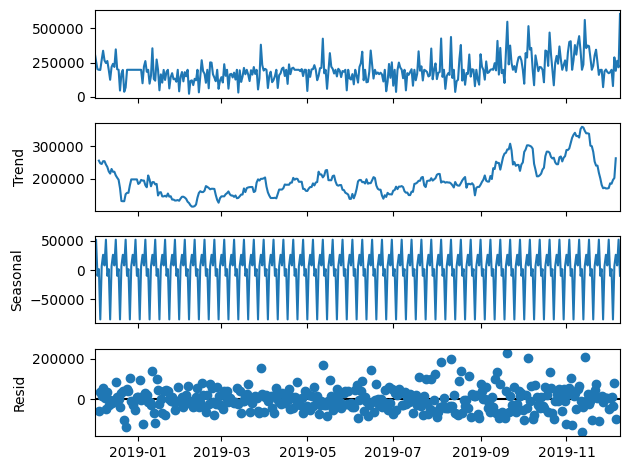

In [50]:
# converted Date column to datetime data type
df['Date'] = pd.to_datetime(df['Date'])

# Group by transaction date and sum revenue
# Create a Time Series of Revenue by Transaction Date
# aggregate the revenue by transaction date
revenue_time_series = df.groupby('Date')['Revenue'].sum().reset_index()
revenue_time_series.set_index('Date', inplace=True)

# find the mean value of the revenue
mean_revenue = revenue_time_series['Revenue'].mean()
print("Mean Revenue: ",mean_revenue)

 # Add Missing Dates
 # you'll want to reindex the DataFrame to include all dates in the range, filling in any gaps with the mean revenue.

 # Create a date range from the start to end of the time series
date_range = pd.date_range(start=revenue_time_series.index.min(), end=revenue_time_series.index.max())

# Reindex the revenue DataFrame to include all dates and Fill missing dates with the mean revenue
revenue_time_series = revenue_time_series.reindex(date_range, fill_value=mean_revenue)

print(revenue_time_series.Revenue.head(10))

# Decompose the Time Series
# Finally, decompose the time series using the seasonal_decompose function from statsmodels.

# Decompose the time series
decomposed = seasonal_decompose(revenue_time_series, model='additive')

# Plot the decomposition
decomposed.plot()
plt.show()



### **Question 2.2:**

We will try to use time series model ARIMA for forecasting the future. you need to find the best model with different parameters on ARIMA model. The parameter range for p,d,q are all from [0, 1, 2]. In total, you need to find out the best model with lowest Mean Absolute Error from 27 choices based on the time from ”Jan-01-2019” to ”Nov-01-2019” (you might need to split the time series to train and test with grid search according to the M05B material).


In [59]:
# Assuming revenue_time_series is already created from previous steps
# Filter the time series to the specified date range
start_date = '2019-01-01'
end_date = '2019-11-01'
revenue_time_series = revenue_time_series[start_date:end_date]

# split into train and test sets
X = revenue_time_series.values
X = X.astype('float32')
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:]
history = [x for x in train]
predictions = list()
MAE = []
p = d = q = range(0, 3)

# Initialize variables to store the best model and its MAE
best_aic = float('inf')
best_pdq = None

# walk-forward validation
for i1 in p:
  for i2 in q:
    for i3 in d:
      for t in range(len(test)):
        model = ARIMA(history, order=(i1,i3,i2))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
  #print('predicted=%f, expected=%f' % (yhat, obs))
      # Calculate MAE
      mae = mean_absolute_error(test, predictions)
      history = [x for x in train]
      predictions = list()
      MAE.append(mae)
      # Update the best model if this one is better
      if mae < best_aic:
          best_aic = mae
          best_pdq = (i1,i2,i3)
      print('Test MAE: %.3f' % mae,'(',i1,i2,i3,')')

print(f'Best ARIMA{best_pdq} - MAE: {best_aic}')

Test MAE: 76228.944 ( 0 0 0 )
Test MAE: 100594.486 ( 0 0 1 )
Test MAE: 176442.474 ( 0 0 2 )
Test MAE: 74302.392 ( 0 1 0 )
Test MAE: 67607.163 ( 0 1 1 )
Test MAE: 100866.357 ( 0 1 2 )
Test MAE: 73021.923 ( 0 2 0 )
Test MAE: 67545.565 ( 0 2 1 )
Test MAE: 68954.259 ( 0 2 2 )
Test MAE: 73865.251 ( 1 0 0 )
Test MAE: 87989.344 ( 1 0 1 )
Test MAE: 119117.744 ( 1 0 2 )
Test MAE: 69481.847 ( 1 1 0 )
Test MAE: 67505.387 ( 1 1 1 )
Test MAE: 88408.755 ( 1 1 2 )
Test MAE: 73314.430 ( 1 2 0 )
Test MAE: 68608.457 ( 1 2 1 )
Test MAE: 68598.622 ( 1 2 2 )
Test MAE: 72901.632 ( 2 0 0 )
Test MAE: 84480.643 ( 2 0 1 )
Test MAE: 112862.847 ( 2 0 2 )
Test MAE: 73013.377 ( 2 1 0 )
Test MAE: 67896.989 ( 2 1 1 )
Test MAE: 85005.497 ( 2 1 2 )
Test MAE: 73594.450 ( 2 2 0 )
Test MAE: 68588.516 ( 2 2 1 )
Test MAE: 88297.400 ( 2 2 2 )
Best ARIMA(1, 1, 1) - MAE: 67505.38691743014


In [ ]:
# Forecasting the next n steps
n_steps = 12  # Number of steps to forecast
forecast = best_model.forecast(steps=n_steps)

# Print or plot the forecast
print(f'Forecast for the next {n_steps} periods:')
print(forecast)


Forecast for the next 12 periods:
2019-09-02    175355.343430
2019-09-03    210219.695497
2019-09-04    222950.367553
2019-09-05    206979.667655
2019-09-06    215619.262422
2019-09-07    215263.473042
2019-09-08    214610.363048
2019-09-09    216438.087951
2019-09-10    216699.878844
2019-09-11    217367.825408
2019-09-12    218164.664548
2019-09-13    218773.091329
Freq: D, Name: predicted_mean, dtype: float64


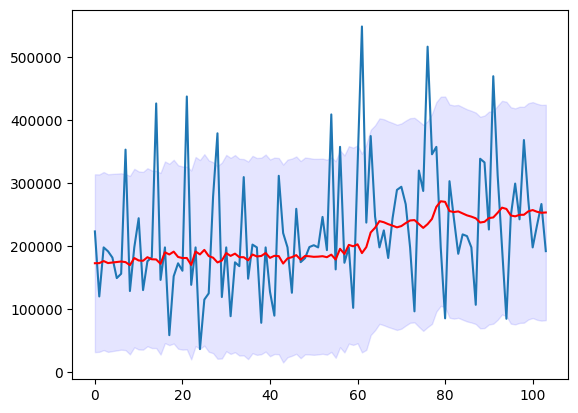

In [64]:
# split into train and test sets
X = revenue_time_series.values
X = X.astype('float32')
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:]
history = [x for x in train]
predictions = list()
best_parameter = [1,1,1]
confidence_interval = []

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(best_parameter[0],best_parameter[1],best_parameter[2]))
    model_fit = model.fit()
    output = model_fit.get_forecast()
    yhat = output.predicted_mean
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    ci = output.conf_int(0.05)
    confidence_interval.append(ci[0])

# plot forecasts against actual outcomes and also the confidence int at 95%
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.fill_between(list(range(len(test))),
                 np.array(confidence_interval)[:,0], np.array(confidence_interval)[:,1],
                alpha=0.1, color='b')
pyplot.show()